# Sampling π with MCMC

In [2]:
import logging
import numpy as np
import plotly.plotly
from plotly import tools
import plotly.offline as py
from plotly.graph_objs import *
import concurrent.futures as futures
from scipy.optimize import minimize_scalar

py.init_notebook_mode(connected=True)

In [3]:
class MarkovChain(object):
    """Samples points using a Markov chain."""
    def __init__(self, num_steps, step_size):
        self.num_steps = num_steps
        self.step_size = step_size
        self.acceptance_ratio = None
        self.x = np.empty((self.num_steps, 2))

    def reset(self):
        self.acceptance_ratio = None
        self.x = np.empty((self.num_steps, 2))

    def run(self, initial_pos=[0., 0.]):
        accept_count = 0

        # Initial position
        self.x[0] = initial_pos

        for i in range(self.num_steps - 1):
            self.x[i+1], accepted = self._move(self.x[i]) 
            accept_count += int(accepted)


        self.accept_ratio = accept_count / self.num_steps

        return self.x

        if show_plot:
            self._show_plot(accept_count)


    def _move(self, current_position):
        step = self._generate_step()
        proposed_position = current_position + step

        if abs(proposed_position[0]) <= 1 and abs(proposed_position[1]) <= 1:
            return proposed_position, True
        else:
            return current_position, False

    def _generate_step(self):
        return np.random.uniform(-self.step_size, self.step_size, 2)

    def samples(self):
        return (np.sum(self.x**2, axis=1) <= 1)*4

    def pi_estimate(self):
        return np.mean(self.samples())

    def plot(self, title):
        lyt = Layout(
            title = title,
            yaxis = dict(scaleanchor="x", domain=[-1,1]),
            yaxis2 = dict(scaleanchor="x2", domain=[-1,1]),
            yaxis3 = dict(scaleanchor="x3", domain=[-1,1]),
            shapes = [{'type': 'circle', 'x0': -1, 'y0': -1, 'x1': 1, 'y1': 1, 'xref':'x', 'yref':'y'},
                      {'type': 'circle', 'x0': -1, 'y0': -1, 'x1': 1, 'y1': 1, 'xref':'x2', 'yref':'y2'},
                      {'type': 'circle', 'x0': -1, 'y0': -1, 'x1': 1, 'y1': 1, 'xref':'x3', 'yref':'y3'}])

        fig = tools.make_subplots(rows=1, cols=3)

        for i, num_steps in enumerate([1000, 4000, 20000]):
            trace = Scatter(x=self.x[:num_steps, 0],
                            y=self.x[:num_steps, 1],
                            mode='lines+markers',
                            name=num_steps)

            fig.append_trace(trace, 1, i+1)
        
        fig['layout'].update(lyt)
        
        # Plot to a static image, performs better since we have too many data points.
        plotly.plotly.image.ishow(fig, width=1000, scale=2)

Let’s plot the Markov chain for different number of steps using a small step size (0.1).

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



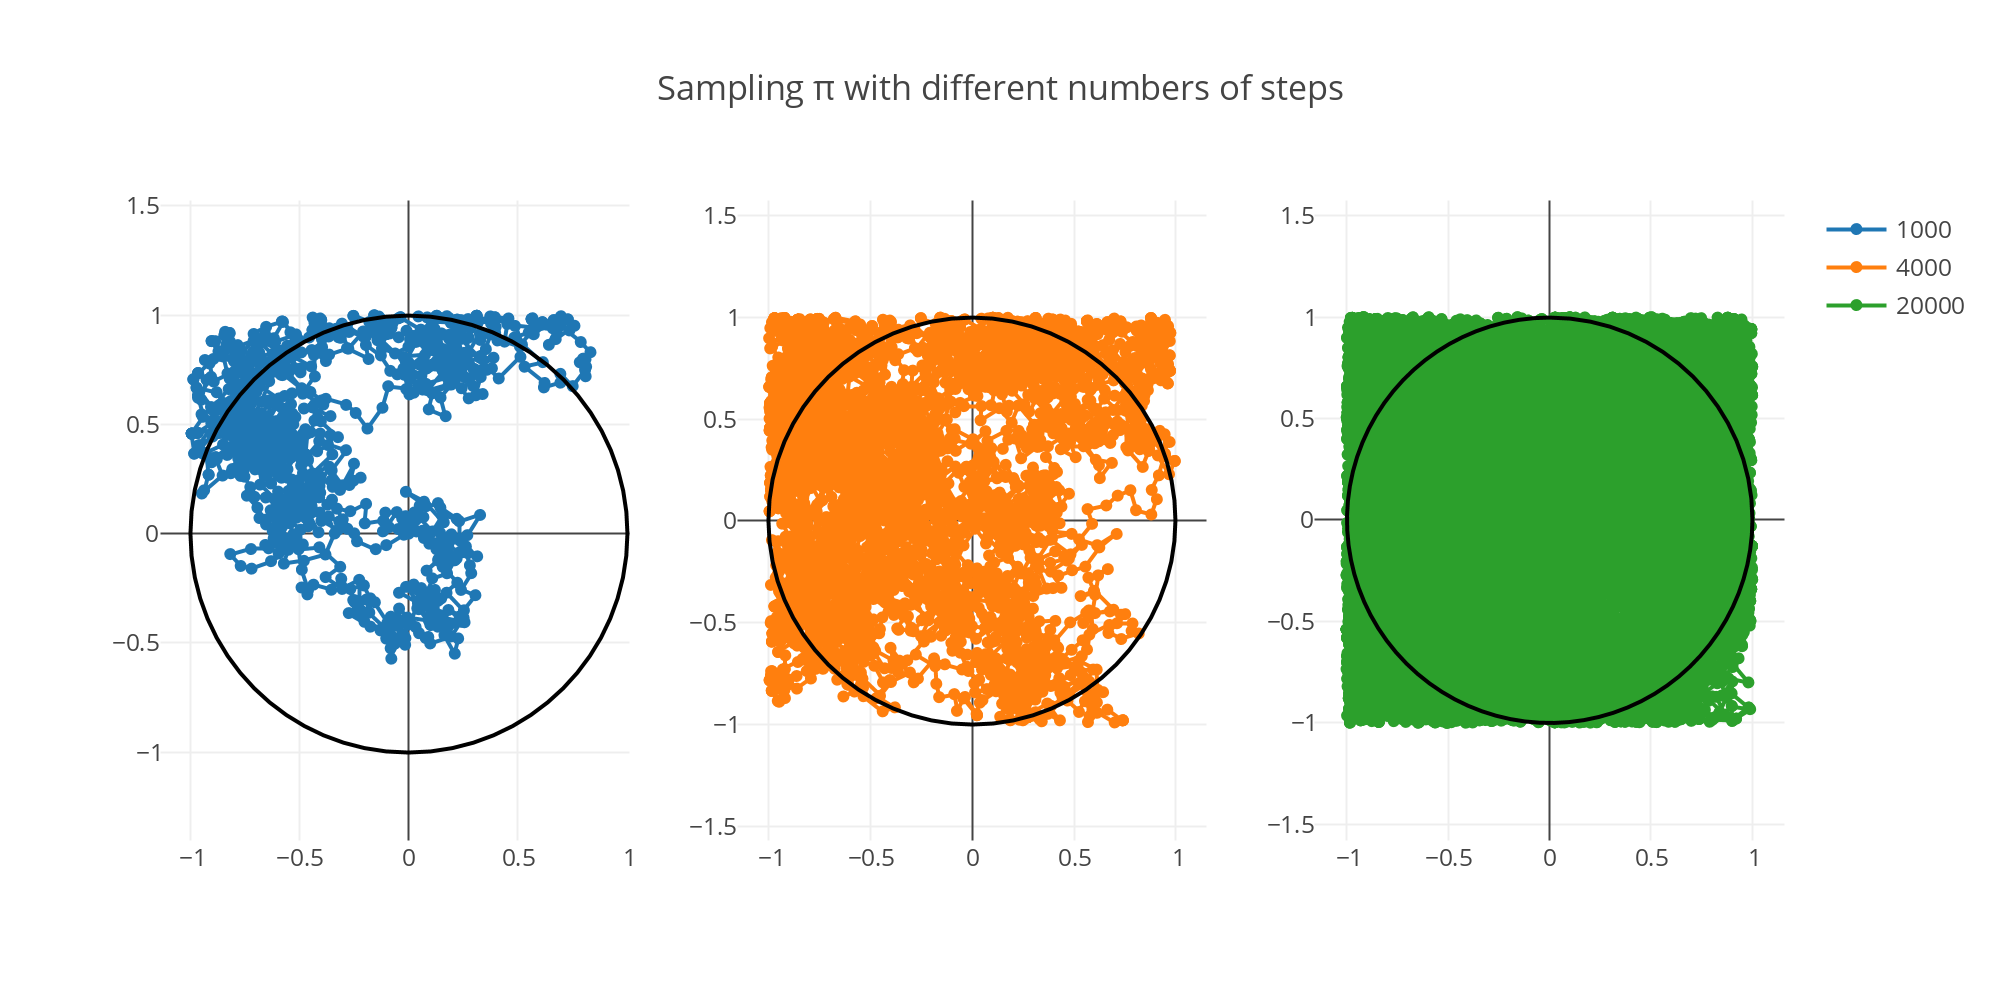

In [14]:
mc = MarkovChain(20000, step_size=0.1)
mc.run()
mc.plot("Sampling π with different numbers of steps")

We see that the step size is not very good, since we get a uniform sampling only for 20000 steps. Let’s try to optimize the step size to get an acceptance ratio of about 0.5.

In [4]:
def optimize_acceptance_ratio(step_size, desired_ratio=0.5):
    """Returns the absolute difference between the acceptance ratio and the desired one given the step size."""
    m = MarkovChain(100000, step_size)
    m.run()

    return abs(m.accept_ratio - desired_ratio)

optimized = minimize_scalar(optimize_acceptance_ratio, bounds=(0.1, 10), tol=1e-2, options=dict(maxiter=100))

if not optimized.success:
    # Convergence is not guaranteed since the function is not deterministic.
    logging.warn("Optimization did non converge! Use the result at your own risk.")

optimal_step_size = optimized.x

print("Optimal step size: {:f}".format(optimal_step_size))

Optimal step size: 1.168146


Let’s do a new Markov chain with the optimal step size.

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



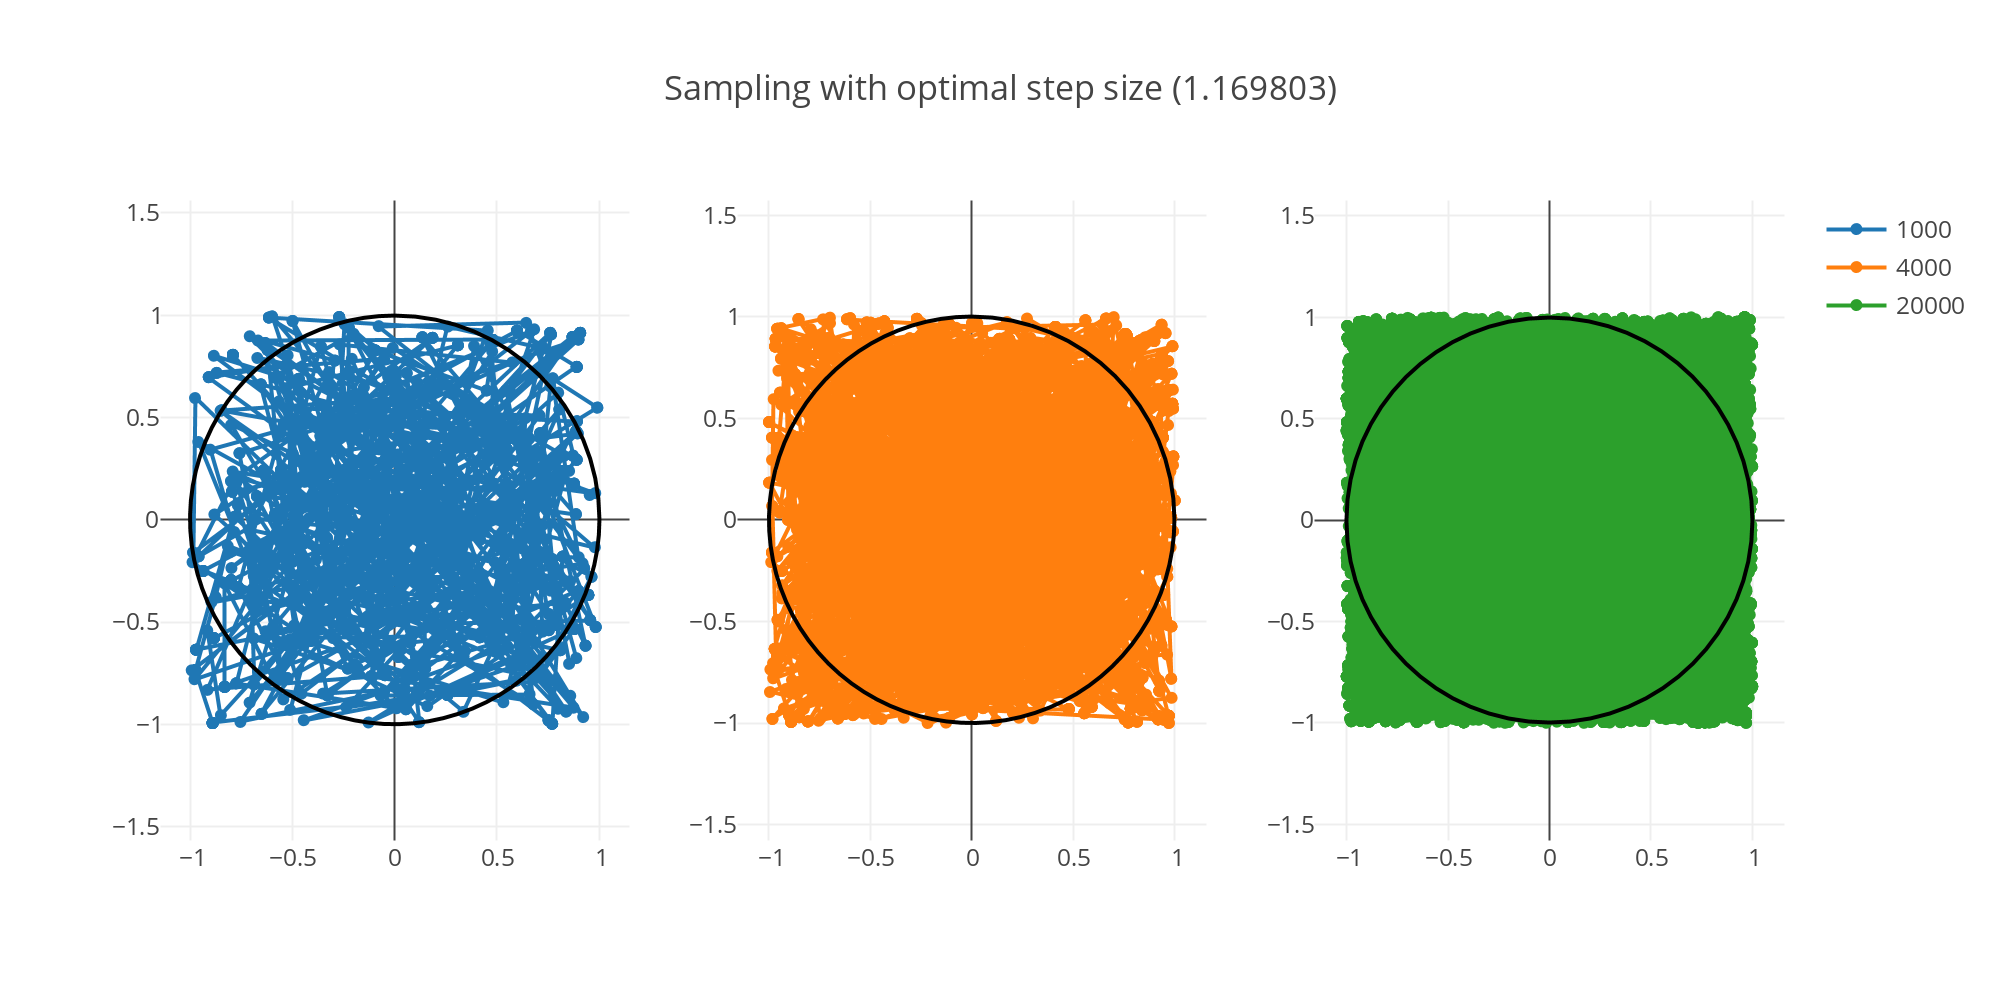

In [39]:
mc_opt = MarkovChain(20000, optimal_step_size)
mc_opt.run()
mc_opt.plot("Sampling with optimal step size ({:f})".format(optimal_step_size))

The result is quite satisfactory: even for short paths we get a quite uniform sampling. 

## Estimating π

In [5]:
NUM_STEPS = 100000

mc_pi = MarkovChain(NUM_STEPS, optimal_step_size)

def estimate_pi():
    """Wraps the estimation of π using the previously defined mc_pi."""
    global mc_pi
    mc_pi.reset()
    mc_pi.run()
    
    return mc_pi.pi_estimate()


with futures.ProcessPoolExecutor() as executor:
    fs = [executor.submit(estimate_pi) for _ in range(100)]

estimates = np.array([f.result() for f in fs])


print("Mean value for π: {:f}".format(np.mean(estimates)))
print("Empirical variance: {:f}".format(np.sqrt(np.var(estimates))))

Mean value for π: 3.145400
Empirical variance: 0.010182


In [26]:
def batching(samples, variance):
    """Apply batching recursively to estimate the variance."""
    if len(samples) <= 1:
        return variance

    if len(samples) % 2 != 0:
        samples = np.append(samples, samples[-1])

    pairs = samples.reshape(len(samples) // 2, 2)

    samples = np.mean(pairs, axis=1)
    variance = np.append(variance, np.var(samples) / len(samples))

    return batching(samples, variance)


mc_pi.reset()
mc_pi.run()
samples = mc_pi.samples()

variance = batching(samples, np.array([]))


py.iplot([Scatter(y=variance, mode="lines+markers")])

In [16]:
def plateau(variance):
    """Try to guess the plateau value automatically."""
    err = 1
    index = 0

    for i in range(len(variance) - 1):
        if variance[i + 1] - variance[i] <= err:
            err = variance[i + 1] - variance[i]
            index = i

    return variance[index]


print("Variance of direct uniform sampling:",
      np.sqrt(np.pi * (4 - np.pi) / NUM_STEPS))
print("Variance estimate through batching:", np.sqrt(plateau(variance)))

Variance of direct uniform sampling: 0.00519303977769
Variance estimate through batching: 0.0150838513199
